# GenerateFramesFiles.ipynb

### Notebook for generating frames files for LIGO data analysis, whether from NR simulation .h5 files, or using the a gravitational waveform surrogate model

Maria Okounkova (mokounkova@flatironinstitute.org)

### Imports and setup

Note that the surrogate model methods will generate deprecation warnings

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import h5py
from astropy import constants as const
from scipy.interpolate import InterpolatedUnivariateSpline
from pycbc.detector import Detector
from gwpy.timeseries import TimeSeries
from gwpy.detector import Channel
import os
from shutil import copyfile
import fileinput
import seaborn as sns
import math
from math import pi
import pycbc
from pycbc.filter.matchedfilter import overlap
import json
from ipynb.fs.full.Auxiliary import ReadExtrapolatedModes, EvaluateSurrogate, SubtractPeakTime, dt_eval, df_eval, \
                                    PadAndProject, EllinKm, ComputeSNR, ComputeMultiDetectorSNR
import gwsurrogate
## if you need the surrogate data: 
## gwsurrogate.catalog.pull('NRSur7dq4')

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 30
matplotlib.rcParams['xtick.labelsize'] = 24
matplotlib.rcParams['ytick.labelsize'] = 24
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['ytick.major.size'] = 10
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 5
matplotlib.rcParams['ytick.minor.size'] = 5
matplotlib.rcParams['legend.fontsize'] = 24
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 1

sur = gwsurrogate.LoadSurrogate('NRSur7dq4')

/home/maria.okounkova/.local/lib/python3.6/site-packages/gwtools/rotations.py:63: UserWarning: Could not import GWFrames, needed for rotations module
  _warnings.warn("Could not import GWFrames, needed for rotations module")
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwtools/__init__.py:11: UserWarning: Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.
  _warnings.warn("Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.")


setting __package__ to gwsurrogate.new so relative imports work
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
setting __package__ to gwsurrogate.new so relative imports work
setting __package__ to gwsurrogate.new so relative imports work


/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:245: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.t = h5file['t_ds'].value
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:272: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_coefs'%(key)].value,
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:273: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'bfOrders': group['%s_bfOrders'%(key)].value
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_%d_coefs'%(key, i)].value,
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_sur

Loaded NRSur7dq4 model


### Helper functions for creating and reading injected parameter dictionaries

In [2]:
def FullParamsDictionary(params_dict):
    """ Given a total mass, q > 1, and spins a_1, a_2, in params_dict, 
        compute m_1, m_2, m_chirp, and chi_eff and add to params_dict
         """
    mass = params_dict['mass']
    q = params_dict['q']
    a_1 = params_dict['a_1']
    a_2 = params_dict['a_2']
    
    m_2 = mass / (1 + q)
    m_1 = q*m_2
    m_chirp = (q/(1+q)**2)**(3/5)*mass
    
    params_dict['m_1'] = m_1
    params_dict['m_2'] = m_2
    params_dict['mass_ratio'] = 1.0/q
    params_dict['chirp_mass'] = m_chirp
    
    ## Assuming aligned spin for now 
    chi_eff = (a_1[2]/m_1 + a_2[2]/m_2)/mass
    params_dict['chi_eff'] = chi_eff
    
    return params_dict

def GetInjectedParameters(p):
    """ Return a dictionary of values from the parameters.json file 
        corresponding to the frames, where p is the path to the file """
    
    f = open(p + '/parameters.json')
    params = json.load(f)
    f.close()
    return params

### Frames files writing method

In [3]:
def GenerateFrames(name, timeH, strainH, timeL, strainL, params_dict):
    """ Generate frames files given hanford and livingston data.
        rh_dir is the directory base directory for the data 
        Also make bayeswave files if necessary """

    frames_dir = 'BilbyPE/' + name + '/Frames/'
    bilby_dir = 'BilbyPE/' + name + '/'
    
    os.makedirs(frames_dir)
    
    dt = dt_eval(timeH)
    segment_start = timeH[0]
    segment_length = timeH[-1] - timeH[0]
    
    H1 = TimeSeries(strainH,sample_rate=1/dt,epoch=timeH[0],channel="H1:LDAS_STRAIN")
    L1 = TimeSeries(strainL,sample_rate=1/dt,epoch=timeL[0],channel="L1:LDAS_STRAIN")

    H1.write(frames_dir + "H1.gwf")
    L1.write(frames_dir + "L1.gwf")
    
    ## Copy over the bilby files and replace path variables
    for file in ['aLIGOZeroDetHighPower-PSD_25Hz.txt', 'Frame.prior', 'Frames.py', 
                 'run_bilby.dag', 'run_bilby.sh', 'run_bilby.sub']:
        
        ## Copy over base file
        copyfile('BilbyPE/Files/' + file, bilby_dir + file)
        
        ## Replace path variables
        with fileinput.FileInput(bilby_dir + file, inplace=True) as f:
            for line in f:
                print(line.replace('FRAMES_DIR', name), end='')
            
    ## Logs directory for Bilby
    os.mkdir(bilby_dir + 'Logs')
    
    ## Bayeswave files
    bw_dir = bilby_dir + 'BayesWave'
    os.mkdir(bw_dir)
    
    # Make the bayeswave cache files
    start_dir = '/home/maria.okounkova/BeyondGRAnalysis/'
    with open(bw_dir + '/H1_Cache.lcf', 'a') as file:
        file.write("-\t-\t-\t-\tfile://localhost" + start_dir + frames_dir + 'H1.gwf' + '\n')
    with open(bw_dir + '/L1_Cache.lcf', 'a') as file:
        file.write("-\t-\t-\t-\tfile://localhost" + start_dir + frames_dir + 'L1.gwf' + '\n')

    # Copy over the bayewave ini files
    copyfile('run_bw.sh', bw_dir + '/run_bw.sh')
    copyfile('dCS.ini', bw_dir + '/dCS.ini')
    
    # Change the path to the cache files in the copied dCS.ini file
    with fileinput.FileInput(bw_dir + '/dCS.ini', inplace=True) as file:
        for line in file:
            print(line.replace('CACHE_DIR', bw_dir), end='')

### Adjust source distance to achieve a target SNR

In [4]:
def TargetSNR(timeH, strainH, timeL, strainL, params_dict, desired_snr):
    """ Update the distance for a given GW waveform in order to 
        achieve a target SNR in H1 [note that (SNR_H1 / SNR_L1) is 
        independent of the distance, and SNR scales with distance as
        SNR ~ 1 / distance
        """
    ## Compute the SNR as it stands
    current_snr = ComputeMultiDetectorSNR(timeH, strainH, timeL, strainL)
    print('Current SNR ', current_snr)
    
    ## Grab the current distance
    current_dist = params_dict['dist_mpc']
    print('Current distance', current_dist)
    
    ## Update the current distance to achieve the desired snr
    updated_dist = current_dist * current_snr / desired_snr
    print('Updated distance', updated_dist)
    
    ## Update the distance in the waveforms 
    strainH = strainH * current_dist / updated_dist
    strainL = strainL * current_dist / updated_dist

    ## Update the distance in the dictionary
    params_dict['dist_mpc'] = updated_dist
    
    return strainH, strainL, params_dict
    

### Create the frames files - evaluate the waveforms, project the data, and write frames files

In [5]:
def EvaluateNRWaveform(p_in, p_out, params_dict, desired_snr, ell = "0p0"):
    
    """
    Given a directory p_out in which the numerical relativity waveform lives (in an SXS format), 
    apply the astrophysical parameters given in params_dict to the waveform, and write frames
    to directory p_out. 
    
    desired_snr corresponds to the SNR we would like for the frames files, which is 
    achieved by adjusting the distance. 
    """
    time, h_plus, h_cross, amp = ReadExtrapolatedModes(p_in, params_dict, interpolate = True)
    timeH, strainH, timeL, strainL = PadAndProject(time, h_plus, h_cross, params_dict)
    
    ## Update distance for target SNR
    strainH, strainL, params_dict = TargetSNR(timeH, strainH, timeL, strainL, params_dict, desired_snr)
    GenerateFrames(p_out, timeH, strainH, timeL, strainL, params_dict)
    
    ## Compute SNRs
    SNR_H = ComputeSNR(timeH, strainH)
    SNR_L = ComputeSNR(timeL, strainL)
    
    ## Print out the parameter values
    params_dict = FullParamsDictionary(params_dict)
    params_dict['source'] = p_in
    params_dict['H_SNR'] = SNR_H
    params_dict['L_SNR'] = SNR_L
    params_dict['ell'] = ell 
    params_dict['ell_km'] = EllinKm(ell, params_dict['mass'])
    with open('BilbyPE/' + p_out + '/parameters.json', 'w') as fp:
        json.dump(params_dict, fp)
    fp.close()

def EvaluateSurrogateWaveform(p_out, params_dict, desired_snr):
    """
    Given a directory dictionary of BBH parameters params_dict, evaluate the surrogate model 
    and write frames to directory p_out. 
    
    desired_snr corresponds to the SNR we would like for the frames files, which is 
    achieved by adjusting the distance. 
    """
    time, h_plus, h_cross, amp = EvaluateSurrogate(sur, params_dict)
    timeH, strainH, timeL, strainL = PadAndProject(time, h_plus, h_cross, params_dict)
    
    ## Update distance for target SNR
    strainH, strainL, params_dict = TargetSNR(timeH, strainH, timeL, strainL, params_dict, desired_snr)
    GenerateFrames(p_out, timeH, strainH, timeL, strainL, params_dict)
    
    ## Compute SNRs
    SNR_H = ComputeSNR(timeH, strainH)
    SNR_L = ComputeSNR(timeL, strainL)

    ## Print out the parameter values
    params_dict = FullParamsDictionary(params_dict)
    params_dict['H_SNR'] = SNR_H
    params_dict['L_SNR'] = SNR_L
    with open('BilbyPE/' + p_out + '/parameters.json', 'w') as fp:
        json.dump(params_dict, fp)
    fp.close()


### Actually generate frames files

In [6]:
## Parameters under consideration for this study
My_Params_Dict = {'dt' : 1/2048, 't_gps' : 1126259462.0, 'peak_time_in_segment' : 8.0, 'segment_length' : 16.0, \
               'dist_mpc' : 400.0, 'mass' : 68.0, 'q' : 1.2212532137858916, \
               'a_1' : [0, 0, 0.329892752405], 'a_2' : [0, 0, -0.439940981499], \
               'f_low' : 0, 'theta' : pi, 'phi' : 0, \
               'ra' : 1.952318922, 'dec' : -1.26967171703, 'pol' : 0.824043851821}
 

#EvaluateNRWaveform('Waveforms/Lev5/dCS_Strain_0p0.h5', 'Hold1', My_Params_Dict, 75, ell="0p0")
EvaluateSurrogateWaveform('Hold3', My_Params_Dict, 75)

Current SNR  94.15956285140955
Current distance 400.0
Updated distance 502.1843352075176


### Plot the frame files

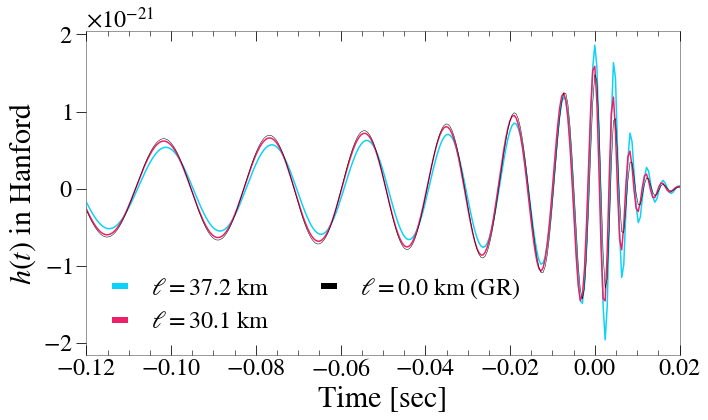

In [7]:
def PlotInjectedWaveforms():
    
    """ Produce a plot of injected waveforms read from frames files """

    fig, ax = plt.subplots(figsize=(10, 6))

    det = "H1"

    base = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/'

    ## Get injected paramters
    truth_dict = GetInjectedParameters(base + 'dCS_0p0_75')
    mass = truth_dict['mass']

    p = base + 'dCS_0p37_75/Frames/'
    sH = TimeSeries.read(source = p + det + '.gwf', channel=det+":LDAS_STRAIN")
    tH = SubtractPeakTime(np.array(sH.times), sH)
    plt.plot(tH, sH, '-', label='$\ell =  %.1f$' % EllinKm('0p37', mass) + ' km', lw=1.5, color='#0cd2fa')

    p = base + 'dCS_0p3_75/Frames/'
    sH = TimeSeries.read(source = p + det + '.gwf', channel=det+":LDAS_STRAIN")
    tH = SubtractPeakTime(np.array(sH.times), sH)
    plt.plot(tH, sH, '-', label='$\ell =  %.1f$' % EllinKm('0p3', mass) + ' km', lw=1.5, color='#ed1f67')

    p = base + 'dCS_0p0_75/Frames/'
    sH = TimeSeries.read(source = p + det + '.gwf', channel=det+":LDAS_STRAIN")
    tH = SubtractPeakTime(np.array(sH.times), sH)
    plt.plot(tH, sH, '-', label='$\ell =  %.1f$' % EllinKm('0p0', mass) + ' km (GR)', lw=0.5, color='black')

    plt.xlim(-0.12, 0.02)
    plt.xlabel('Time [sec]')
    plt.ylabel(r'$h(t)$ in Hanford')
    legend = plt.legend(fontsize=24, loc = 'lower left', ncol=2, frameon=False)
    plt.grid()
    plt.tight_layout()
    plt.savefig('InjectedWaveforms.pdf')
    plt.show()
    
PlotInjectedWaveforms()